In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps


In [37]:
class ShortConn2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        return self.bn(self.conv(x))

In [38]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # 1 to 1 convolution for skip connect, projection from 32 to 16 with stride of 2
        self.sc1 = ShortConn2d(3, 20, 2)
        
        # input image shape = 3x32x32
        # 3 input image channels, 10 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # input image shape = 10x16x16
        # 10 input image channels, 20 output channels, 3x3 square convolution, stride 1, padding 1
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(20)
        
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # input image shape = 20x8x8
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.act3 = nn.ReLU()
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        res1 = self.sc1(x)
        # conv1 then relu then max pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # conv2 relu max pool
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x + res1)
        x = self.pool2(x)
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        
        return x
    

In [54]:
PATH = './cifar_res_exp_adam_reg.pth'

epochs = 20             # Total epochs.
iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.
res_exp_reg_avg_train_losses = []   # Avg. losses.
res_exp_reg_train_accuracies, res_exp_reg_test_accuracies = [], []  # Train and test accuracies.

res_exp_reg = ResNet()     # Create the network instance.
res_exp_reg.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(res_exp_reg.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

# add scheduling
exp_scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = res_exp_reg(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            res_exp_reg_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
                            

    # exponential scheduling
    exp_scheduler.step()
        
    # Set the model to evaluation mode.
    res_exp_reg.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    res_exp_reg_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = res_exp_reg(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    res_exp_reg_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    res_exp_reg.train()     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': res_exp_reg.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': res_exp_reg_avg_train_losses[epoch],
            'train_accuracy': res_exp_reg_train_accuracies[epoch],
            'test_accuracy': res_exp_reg_test_accuracies[epoch],
            }, PATH)
              

print('Finished Training.')

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.467
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.374
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.397
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.296
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.258
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.296
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.248
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.139
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.238
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.172
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.217
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.174
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.156
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.151
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.208
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [46]:
PATH = './cifar_res_exp_adam.pth'

epochs = 20             # Total epochs.
iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.
res_exp_avg_train_losses = []   # Avg. losses.
res_exp_train_accuracies, res_exp_test_accuracies = [], []  # Train and test accuracies.

res_exp = ResNet()     # Create the network instance.
res_exp.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(res_exp.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# add scheduling
exp_scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = res_exp(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            res_exp_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
                            

    # exponential scheduling
    exp_scheduler.step()
        
    # Set the model to evaluation mode.
    res_exp.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    res_exp_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = res_exp(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    res_exp_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    res_exp.train()     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': res_exp.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': res_exp_avg_train_losses[epoch],
            'train_accuracy': res_exp_train_accuracies[epoch],
            'test_accuracy': res_exp_test_accuracies[epoch],
            }, PATH)
              

print('Finished Training.')

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.436
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.373
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.213
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.190
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.182
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.043
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.133
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.032
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.062
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.042
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.028
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 0.908
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.029
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.004
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 0.915
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [47]:
PATH = './cifar_res_cyclic_adam.pth'

epochs = 20             # Total epochs.
iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.
res_cyclic_avg_train_losses = []   # Avg. losses.
res_cyclic_train_accuracies, res_cyclic_test_accuracies = [], []  # Train and test accuracies.

res_cyclic = ResNet()     # Create the network instance.
res_cyclic.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(res_cyclic.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

# add cyclic scheduling, use one cyclic because of momentum bug with adam
# one cyclic support betas
cyclic_scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=0.01, epochs=epochs, steps_per_epoch=iter_n)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = res_cyclic(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        # one cyclic scheduling, unlike exp scheduling, step after each mini-batch
        cyclic_scheduler.step()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            res_cyclic_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
            
        
    # Set the model to evaluation mode.
    res_cyclic.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    res_cyclic_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = res_cyclic(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    res_cyclic_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    res_cyclic.train()     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': res_cyclic.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': res_cyclic_avg_train_losses[epoch],
            'train_accuracy': res_cyclic_train_accuracies[epoch],
            'test_accuracy': res_cyclic_test_accuracies[epoch],
            }, PATH)
              
              

print('Finished Training.')

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.426
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.308
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.310
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.275
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.209
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.248
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.123
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.154
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.189
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.157
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.089
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.106
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.326
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.332
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.346
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

In [77]:
PATH = './cifar_res_cyclic_adam_reg.pth'

epochs = 20             # Total epochs.
iter_n = len(trainset.data) // 4  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 5 # Print frequency, need to be multiple of record_freq.
res_cyclic_reg_avg_train_losses = []   # Avg. losses.
res_cyclic_reg_train_accuracies, res_cyclic_reg_test_accuracies = [], []  # Train and test accuracies.

res_cyclic_reg = ResNet()     # Create the network instance.
res_cyclic_reg.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer but with weight_decay (act as L2 regularization).
opt = optim.Adam(res_cyclic_reg.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

# add cyclic scheduling, use one cyclic because of momentum bug with adam
# one cyclic support betas
cyclic_scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=0.01, epochs=epochs, steps_per_epoch=iter_n)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    test_total = 0   
    test_correct = 0
    
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = res_cyclic_reg(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        # one cyclic scheduling, unlike exp scheduling, step after each mini-batch
        cyclic_scheduler.step()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        
        # Record training loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            res_cyclic_reg_avg_train_losses.append(avg_train_loss)
            running_train_loss = 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}] avg-{}-iter mini-batch train_loss: {:.3f}'.format(
                    epoch, i, record_freq, avg_train_loss))
            
        
    # Set the model to evaluation mode.
    res_cyclic_reg.eval() 
    
    # calculating a train accuracy
    train_accuracy = 100 * train_correct / train_total
    res_cyclic_reg_train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        for data in testloader:  
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            test_output = res_cyclic_reg(inputs)
            # get the class which has the maximum probability
            _, predicted = torch.max(test_output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    res_cyclic_reg_test_accuracies.append(test_accuracy)
    # Set the model back to training mode.
    res_cyclic_reg.train()     
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': res_cyclic_reg.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': res_cyclic_reg_avg_train_losses[epoch],
            'train_accuracy': res_cyclic_reg_train_accuracies[epoch],
            'test_accuracy': res_cyclic_reg_test_accuracies[epoch],
            }, PATH)
              

print('Finished Training.')

[epoch: 0, i:  2499] avg-125-iter mini-batch train_loss: 1.541
[epoch: 0, i:  4999] avg-125-iter mini-batch train_loss: 1.397
[epoch: 0, i:  7499] avg-125-iter mini-batch train_loss: 1.442
[epoch: 0, i:  9999] avg-125-iter mini-batch train_loss: 1.420
[epoch: 0, i: 12499] avg-125-iter mini-batch train_loss: 1.343
[epoch: 1, i:  2499] avg-125-iter mini-batch train_loss: 1.377
[epoch: 1, i:  4999] avg-125-iter mini-batch train_loss: 1.393
[epoch: 1, i:  7499] avg-125-iter mini-batch train_loss: 1.458
[epoch: 1, i:  9999] avg-125-iter mini-batch train_loss: 1.443
[epoch: 1, i: 12499] avg-125-iter mini-batch train_loss: 1.381
[epoch: 2, i:  2499] avg-125-iter mini-batch train_loss: 1.466
[epoch: 2, i:  4999] avg-125-iter mini-batch train_loss: 1.496
[epoch: 2, i:  7499] avg-125-iter mini-batch train_loss: 1.586
[epoch: 2, i:  9999] avg-125-iter mini-batch train_loss: 1.553
[epoch: 2, i: 12499] avg-125-iter mini-batch train_loss: 1.647
[epoch: 3, i:  2499] avg-125-iter mini-batch train_loss

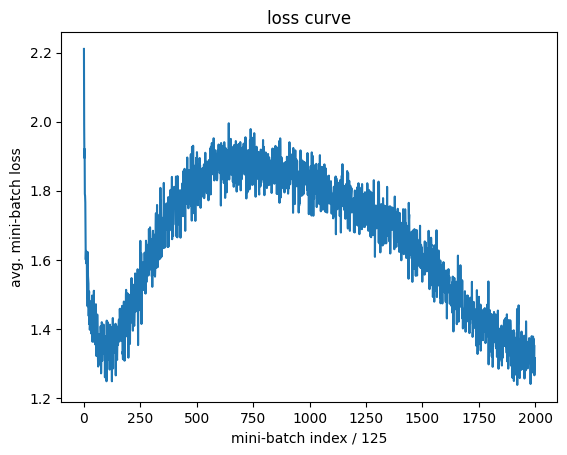

In [78]:
plt.plot(res_cyclic_reg_avg_train_losses)
plt.title('loss curve')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

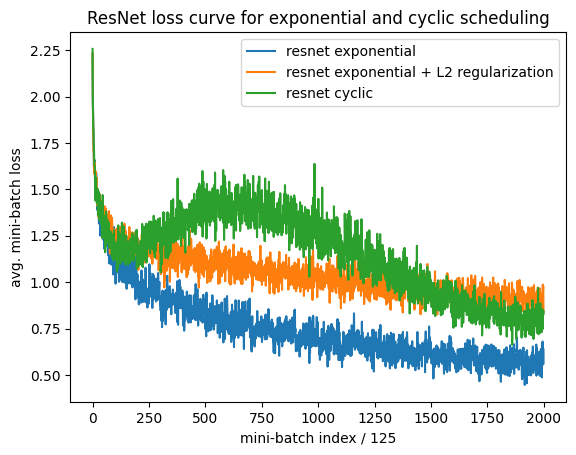

In [67]:
plt.plot(res_exp_avg_train_losses)
plt.plot(res_exp_reg_avg_train_losses)
plt.plot(res_cyclic_avg_train_losses)
plt.title('ResNet loss curve for exponential and cyclic scheduling')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['resnet exponential', 
            'resnet exponential + L2 regularization',
            'resnet cyclic',
            # 'resnet cyclic + L2 regularization' 
            ])
plt.show()

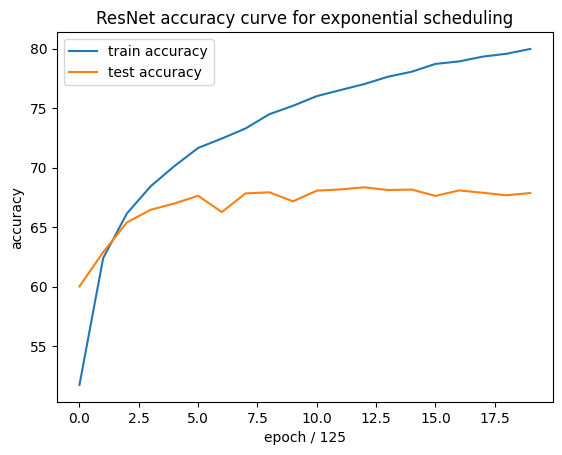

In [68]:
plt.plot(res_exp_train_accuracies)
plt.plot(res_exp_test_accuracies)
plt.title('ResNet accuracy curve for exponential scheduling')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

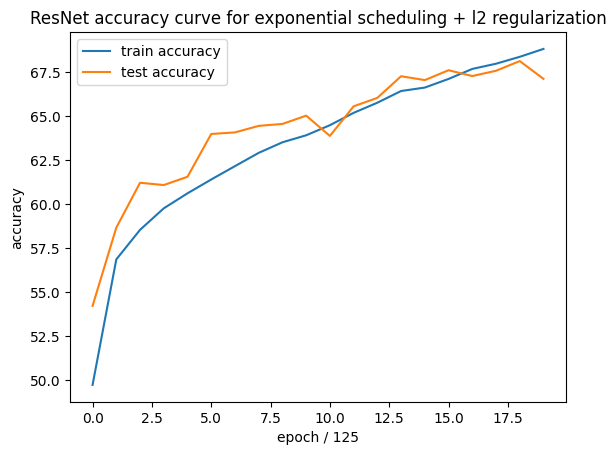

In [82]:
plt.plot(res_exp_reg_train_accuracies)
plt.plot(res_exp_reg_test_accuracies)
plt.title('ResNet accuracy curve for exponential scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

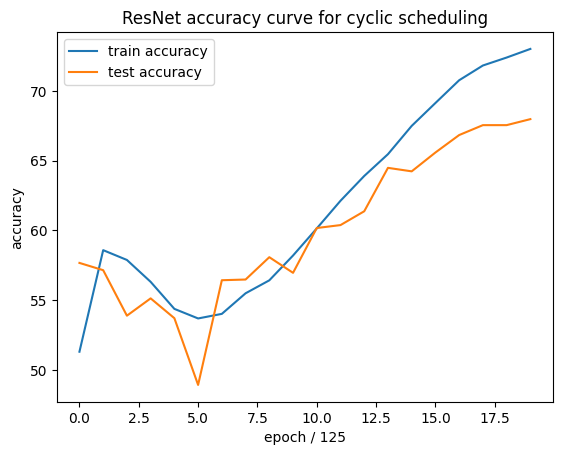

In [83]:
plt.plot(res_cyclic_train_accuracies)
plt.plot(res_cyclic_test_accuracies)
plt.title('ResNet accuracy curve for cyclic scheduling')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

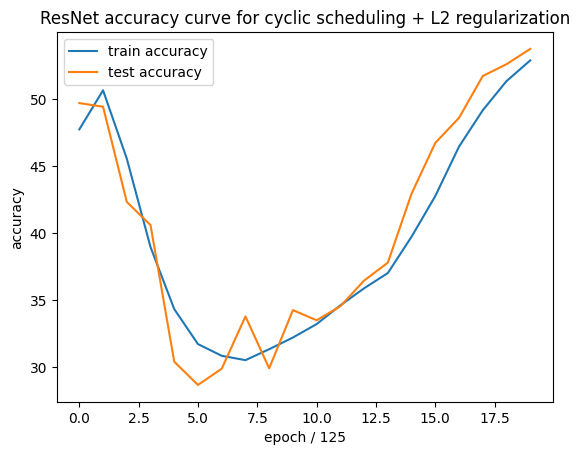

In [84]:
plt.plot(res_cyclic_reg_train_accuracies)
plt.plot(res_cyclic_reg_test_accuracies)
plt.title('ResNet accuracy curve for cyclic scheduling + L2 regularization')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

In [81]:
print('Accuracy of the Resnet on the 10000 test images\
      \nExponential Scheduling: %.2f %% \
      \nExponential Scheduling with L2 Regularization: %.2f %%\
      \nCyclic Scheduling: %.2f %% \
      \nCyclic Scheduling with L2 egularization: %.2f %%' % (
    res_exp_test_accuracies[-1],
    res_exp_reg_test_accuracies[-1], 
    res_cyclic_test_accuracies[-1], 
    res_cyclic_reg_test_accuracies[-1]))

Accuracy of the Resnet on the 10000 test images      
Exponential Scheduling: 67.87 %       
Exponential Scheduling with L2 Regularization: 67.12 %      
Cyclic Scheduling: 67.97 %       
Cyclic Scheduling with L2 egularization: 53.72 %


#### Model Ensemble

In [95]:
# every item in the list is a essemble of models
essembles = []

# put all models in a list, so we can easily iterate over them to create permutations
models = [res_exp, res_exp_reg, res_cyclic, res_cyclic_reg]
model_names = ["ResNet-Exp", "ResNet-Exp-L2_Reg", "ResNet-Cyc", "ResNet-Cyc-L2_Reg"]

# loop for all possible combintation of 2 models
for i in range(len(models)):
    for j in range(i+1, len(models)):
        essembles.append([models[i], models[j]])
        
# loop for all possible combintation of 3 models
for i in range(len(models)):
    for j in range(i+1, len(models)):
        for k in range(j+1, len(models)):
            essembles.append([models[i], models[j], models[k]])
            
# loop for all possible combintation of 4 models
essembles.append(models)

# set all models to eval mode
# this works because python list item share memory with the original model
for model in models:
    model.eval()

In [97]:
# corrects = [0] * len(essembles)
# totals = [0] * len(essembles)

winner_essemble = None
winner_essemble_name = ""
winner_accuracy = 0

# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
        
#         # use the essemble to get the prediction in double for loop
#         for i, essemble in enumerate(iterable=essembles, start=0):
            
#             outputs = [model(images).data for model in essemble]
            
#             # each essemble is a list of models, we want to averge their output
#             enssembled_outputs = torch.stack(outputs, dim=0).mean(dim=0)
            
#             # predicted variable is the index of the maximum value in the enssembled_outputs
#             # which is the class that the essemble predicted
#             _, predicted = torch.max(enssembled_outputs, 1)
#             totals[i] += labels.size(0)
#             corrects[i] += (predicted == labels).sum().item()
        
for i, essemble in enumerate(iterable=essembles, start=0):
    print('Combination of essembled network:', end =" ")
    
    essemble_name = ""
    for model in essembles[i]:
        model_name = model_names[models.index(model)]
        essemble_name += model_name + " "
        print(model_name, end =" ")
        
    accuracy = 100 * corrects[i] / totals[i]
    print('\nTest Accuracy: %.2f %%\n' % (accuracy))
    if accuracy > winner_accuracy:
        winner_accuracy = accuracy
        winner_essemble = essemble
        winner_essemble_name = essemble_name

print('\nThe winner essemble is:', winner_essemble_name + 'with accuracy of:', winner_accuracy)
# print('Accuracy of the essembled network on the 10000 test images: %.2f %%' % (
#         100 * correct / total))

Combination of essembled network: ResNet-Exp ResNet-Exp-L2_Reg 
Test Accuracy: 71.85 %

Combination of essembled network: ResNet-Exp ResNet-Cyc 
Test Accuracy: 71.37 %

Combination of essembled network: ResNet-Exp ResNet-Cyc-L2_Reg 
Test Accuracy: 68.63 %

Combination of essembled network: ResNet-Exp-L2_Reg ResNet-Cyc 
Test Accuracy: 70.97 %

Combination of essembled network: ResNet-Exp-L2_Reg ResNet-Cyc-L2_Reg 
Test Accuracy: 67.77 %

Combination of essembled network: ResNet-Cyc ResNet-Cyc-L2_Reg 
Test Accuracy: 65.97 %

Combination of essembled network: ResNet-Exp ResNet-Exp-L2_Reg ResNet-Cyc 
Test Accuracy: 72.69 %

Combination of essembled network: ResNet-Exp ResNet-Exp-L2_Reg ResNet-Cyc-L2_Reg 
Test Accuracy: 71.48 %

Combination of essembled network: ResNet-Exp ResNet-Cyc ResNet-Cyc-L2_Reg 
Test Accuracy: 71.05 %

Combination of essembled network: ResNet-Exp-L2_Reg ResNet-Cyc ResNet-Cyc-L2_Reg 
Test Accuracy: 70.03 %

Combination of essembled network: ResNet-Exp ResNet-Exp-L2_Reg

Check accuracy for each class, just for fun

In [ ]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = [model(images).data for model in models]
        enssembled_outputs = torch.stack(outputs, dim=0).sum(dim=0)
        _, predicted = torch.max(enssembled_outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

#### Description
##### Ran 6 different models with fixed learning rate 1e-3 and Adam optimizer with no weight decay (L2 Regularization) for gradient update.
Before doing any experiment, I gathered some information from the average pooling based model as described in Q5.

I first plot the training loss curve at a frequency of 100 times per epoch to understand the training process. Then I plot the accuracy comparison once per epoch (computing accuracy is expensive) to make more observations.

Judging from the training loss curve alone, the model converge nicely and the loss does not fluctuate too much toward the end of the training,

Observing the accuracy comparison chart from average pooling based model as described in Q5, we can see the gap between train accuracy and test accuracy start getting bigger in each epoch; more precisely, test accuracy does not increase in proportion to train accuracy. This is a clear sign of overfitting.

To address overfitting, some form of regularization is needed, therefore I decided to try out various techniques such as Batch Normalization and Dropout. I've also included max pooling because it's a more common practice than average pooling to extract features from the input.

For Batch Normalization before each ReLU layer for Gaussian distributed input

1. Average Pooling (same architecture as the write-up)
2. Average Pooling + 
3. 
4. 